# Document Clustering with Unsupervised Learning

## Author: Arash Shamseddini

In this script, I have made an attempt to build a an unsupervised model for ["Document Clustering"](https://en.wikipedia.org/wiki/Document_clustering).

The idea for this work is inspired by the Kaggle's [Food.com recipes corpus](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews, however in this analysis I will only focus on recipes and not on recipe reviews. The recipes are present in `RAW_recipes.csv`.

The goal is to extract main categories or groupings of recipes based on their names.

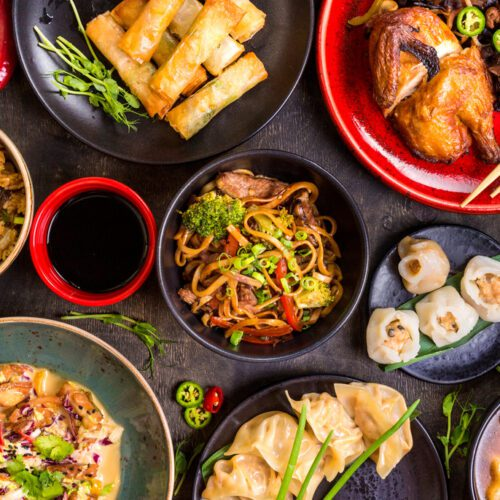

In [39]:
from IPython import display
# Image 1
display.Image("images/food.jpg")

In [40]:
# Necessary imports

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

pd.set_option("display.max_colwidth", 0)

### 1- Data set

Let's read the data in.

In [41]:
# Reading the data in 
orig_recipes_df = pd.read_csv("RAW_recipes.csv")
orig_recipes_df.shape

(231637, 12)

The dataset is quite large, and for the purpose of this script I will use a sample of the dataset. The helper function `get_recipes_sample` as defined below carries out some preliminary preprocessing and returns a sample with most frequent tags.

In [42]:
# Defining the helper get_recipes_sample()
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.dropna()

    # Remove rows with duplicate names.
    orig_recipes_df = orig_recipes_df.drop_duplicates("name")

    # Remove rows where recipe name has less than 5 characters.
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]

    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [43]:
# Defining the recipes_df data set
recipes_df = get_recipes_sample(orig_recipes_df)
# Let's take a look at the data set head
recipes_df.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
42,i yam what i yam muffins,93958,45,133174,2004-06-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]",10,"['preheat oven to 375 degrees', 'spray muffin tin with non-stick cooking spray and set aside', 'place the raisins in a small bowl and pour the 1 / 4 cup boiling water over them', 'cover and set aside while preparing batter', 'combine the flours , cocoa , baking powder , cinnamon , cloves , baking soda , and salt', 'lightly beat eggs with sorghum , oil , mashed yams and orange juice', 'add the egg mixture and buttermilk alternately to the dry ingredients , stir until well blended', 'drain the raisins and add to batter along with orange peel', 'spoon batter into prepared muffin tins , sprinkle 1 / 4 to 1 / 2 tsp of granulated sugar over each muffin', 'bake in preheated oven for 15 to 20 minutes']","these muffins may have slightly different ingredients but the end result is a wonderful rich, moist muffin. the sugar sprinkled on top before cooking gives a slightly sweet crunch and cracked glazed appearance.","['all-purpose flour', 'buckwheat flour', 'unsweetened cocoa', 'baking powder', 'baking soda', 'salt', 'ground cinnamon', 'ground cloves', 'sorghum', 'eggs', 'yam', 'low-fat buttermilk', 'orange rind', 'orange juice', 'canola oil', 'raisins', 'boiling water', 'granulated sugar']",18
101,to your health muffins,61973,40,33823,2003-05-12,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[159.0, 8.0, 58.0, 10.0, 7.0, 4.0, 8.0]",5,"['blend together in large bowl flour , bran , brown sugar , baking soda , salt , cinnamon , carrots and raisins', 'in second bowl , beat buttermilk , oil , egg and vanilla', 'add liquid ingredients to dry ingredients and mix just until moistened', 'spoon into 12 greased or paper-lined muffin cups', 'bake at 375f for 20 minutes']","these muffins sound like they are very healthy for you, and pretty easy to make. another one of my great finds. to your health. enjoy","['whole wheat flour', 'natural bran', 'brown sugar', 'baking soda', 'salt', 'cinnamon', 'carrot', 'raisins', 'buttermilk', 'corn oil', 'egg', 'vanilla']",12
129,250 00 chocolate chip cookies,118843,20,145599,2005-04-24,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'drop-cookies', 'desserts', 'easy', 'cookies-and-brownies', '3-steps-or-less']","[5286.9, 427.0, 1630.0, 159.0, 163.0, 656.0, 224.0]",3,"['mix all ingredients together just until blended', 'spoon large tbspfuls onto a baking sheet', 'bake at 350 for 10-14 minutes']",these are great! the perfect name for them!,"['butter', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'oatmeal', 'salt', 'baking powder', 'baking soda', 'chocolate chips', ""hershey's semi-sweet baking chocolate"", 'nuts']",13
138,lplermagronen,455351,55,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'preparation']","[651.8, 33.0, 12.0, 16.0, 32.0, 63.0, 33.0]",15,"['heat oven to 375f set a large pot of salted water to boil', 'heat butter / oil over medium-low heat in a frying pan', 'add onions and fry them until golden brown', 'add penne and potatoes to the salted water', 'stir to make sure pasta doesnt stick together', 'cook until tender , about 15 minutes', 'drain penne and potatoes', 'combine milk / cream with salt and pepper', 'in an ovenproof casserole dish , place 1 / 3 of the penne-potatoes , sprinkle with 1 / 2 of the grated cheese', 'make another layer with 1 / 3 of the penne-potatoes , sprinkle with the other 1 / 2 of the grated cheese', 'top with the remaining 1 / 3 of the penne-potatoes', 'pour the seasoned milk / cream evenly over the top', 'spread the browned onions on top', 'bake covered for 10-15 minutes until steaming hot and cheese is melted', 'serve with warmed applesauce']","known as swiss mac n chee

In [44]:
# Let's take a look at the name column
recipes_df["name"]

42        i yam what i yam  muffins    
101       to your health  muffins      
129       250 00 chocolate chip cookies
138       lplermagronen                
163       california roll   salad      
                   ...                 
231430    zucchini wheat germ cookies  
231514    zucchini blueberry bread     
231547    zucchini salsa burgers       
231596    zuppa toscana                
231629    zydeco salad                 
Name: name, Length: 9100, dtype: object

In the rest of this analysis, I will use recipes_df above, a sample of the original dataset.

### 2- EDA

Let's analyse the data a little in depth and see what are the longest and shortest recipe names.

In [45]:
# Priniting longest and shortest recipe names
print("The shortest recipe name is: ", min(recipes_df['name'], key=len))
print("The longest recipe name is: ", max(recipes_df['name'], key=len))

The shortest recipe name is:  bread
The longest recipe name is:  baked tomatoes with a parmesan cheese crust and balsamic drizzle


This seems to make sense.

A useful insight from the data set would be the distribution of the the time it takes (`minutes`) for each recipe. Let's plot it here:

C:\Users\mohamadian\miniconda3\envs\563\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'minutes')]

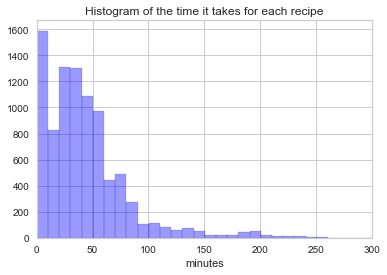

In [46]:
# Plotting the distribution of the time for the recipes
plot = sns.distplot(recipes_df['minutes'], hist=True, kde=False, 
             bins=int(180/0.5), color = 'blue',
             hist_kws={'edgecolor':'black'})

plot.set(xlim=(0, 300))
# Add labels
plot.set(title = 'Histogram of the time it takes for each recipe')
plot.set(xlabel = 'minutes')

It looks like the majority of the recipes in this data set take less than **75** minutes to prepare.

### 3- Pre-processing

Now, I will use ["Sentence Embedding"](https://en.wikipedia.org/wiki/Sentence_embedding) representation of the recipe names. This technique is an alternative representation of text which usually works better than simple [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation.

In [47]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [48]:
# Creating sentence embedding representation for recipe names
emb_sents_recipe = embedder.encode(recipes_df["name"].tolist())
emb_sent_recipe_df = pd.DataFrame(emb_sents_recipe, index=recipes_df.index)
emb_sent_recipe_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
42,-0.333475,0.227865,-0.307339,0.410549,0.917104,-0.345506,0.305811,0.256676,-0.147711,0.040728,...,-0.053025,-0.209463,0.362418,-0.246086,0.208379,-0.024874,0.506561,0.197739,-0.386422,-0.002184
101,-0.024523,0.246223,-0.055709,0.358273,0.454786,-0.088055,0.260368,0.231947,0.093013,-0.007834,...,0.144860,-0.435459,0.208344,-0.002655,-0.081200,-0.130489,0.452378,0.186310,-0.278500,0.028580
129,-0.026562,0.194672,0.038101,-0.099181,0.653784,-0.230868,0.064517,0.001376,-0.061280,0.232094,...,0.169605,0.239354,0.392649,0.271398,-0.093971,0.060101,-0.281417,0.133210,-0.122344,-0.109864
138,-0.168002,-0.219219,0.330761,0.302196,-0.173169,0.204557,0.192390,0.140976,0.303174,0.038062,...,0.019095,-0.002448,0.437833,0.563785,0.033442,0.187658,0.529252,-0.233786,0.509932,0.410714
163,0.061076,-0.333798,0.242906,0.395978,-0.466468,0.496505,-0.136754,0.122097,0.114249,0.065318,...,0.044438,-0.213657,0.410353,-0.233599,-0.224423,0.094331,0.173351,0.105781,-0.114749,-0.150677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231430,-0.009713,0.200162,0.018329,0.237816,0.748988,0.121919,0.087918,0.216755,-0.291040,0.074165,...,-0.120458,0.162877,0.480064,0.235902,0.146278,0.252980,-0.063640,-0.066044,-0.133067,-0.034040
231514,-0.106531,-0.034574,0.160070,0.258504,0.882480,0.091899,0.008815,0.372013,-0.266542,0.085018,...,0.063240,-0.099132,0.332693,0.031868,0.582796,0.216874,0.241107,0.091758,-0.261551,-0.082310
231547,0.016149,-0.053035,-0.035097,-0.021836,0.735160,0.245519,-0.151837,0.003954,0.102566,0.001362,...,0.102296,0.023821,0.602685,-0.067071,0.177534,0.253982,0.242439,-0.436001,-0.053909,0.012423
231596,0.026659,0.202483,0.344634,-0.138708,0.514423,0.630948,-0.003164,-0.102897,-0.434899,-0.192056,...,-0.162457,0.130696,0.113644,0.186650,-0.155392,0.130507,1.146238,-0.240860,0.236830,0.177123


### 4- Modeling

To start with, I will train a [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) model with a reasonable range of `n_clusters` and to choose the best `k` value I will be using both the [elbow](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) and [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) methods.

I will use [yellowbrick](https://www.scikit-yb.org/en/latest/) package for visualization.

**The Elbow Method**

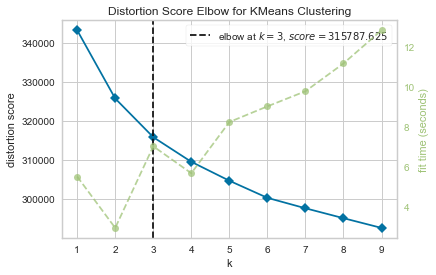

In [49]:
from yellowbrick.cluster import KElbowVisualizer

#Plotting a yellowbrick plot
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))

# Fitting the data to the visualizer
visualizer.fit(emb_sents_recipe) 
visualizer.show();

**The Silhouette Method**

In [50]:
from yellowbrick.cluster import SilhouetteVisualizer

**n_clusters = 2**

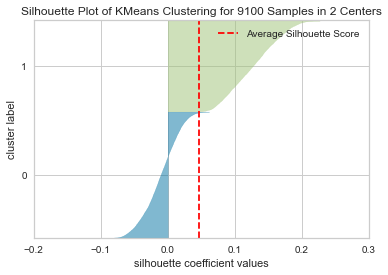

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 9100 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [51]:
# Training KMeans for of n_clusters = 2 and cheecking Silhouette plot
model = KMeans(2, random_state=123)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
# Fit the data to the visualizer
visualizer.fit(emb_sents_recipe)  
# Finalize and render the figure
visualizer.show()

**n_clusters = 3**

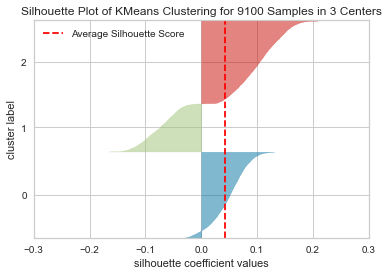

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 9100 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [52]:
# Training KMeans for of n_clusters = 3 and cheecking Silhouette plot
model = KMeans(3, random_state=123)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
# Fit the data to the visualizer
visualizer.fit(emb_sents_recipe)  
# Finalize and render the figure
visualizer.show()

**n_clusters = 4**

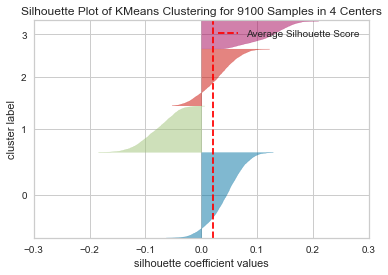

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 9100 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [53]:
# Training KMeans for of n_clusters = 4 and cheecking Silhouette plot
model = KMeans(4, random_state=123)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
# Fit the data to the visualizer
visualizer.fit(emb_sents_recipe)  
# Finalize and render the figure
visualizer.show()

Based on the yellowbrick plots above, it is obvious that using the Elbow Method, `K=3` should be picked since the inertia decreases when clusters are greater than `3` but it is not a big improvement. Using the Silhouette Method, `K=3` is also the best pick as here higher values indicate well-separated clusters and we want a balance of data points in clusters.

Let's visualize the clusters to get a better sense of reasonable number of clusters for this problem.

In order to do this, I will train `K-Means` algorithm for the values of `n_clusters` from the previous step and visualize the clusters in each experiment. 

As for the visualization itself, I will define a helper `plot_pca_clusters` function as below:

In [54]:
# Defining the helper plot_pca_clusters()
def plot_pca_clusters(
    data,
    cluster_labels,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()

    plt.show()

**n_clusters = 2**

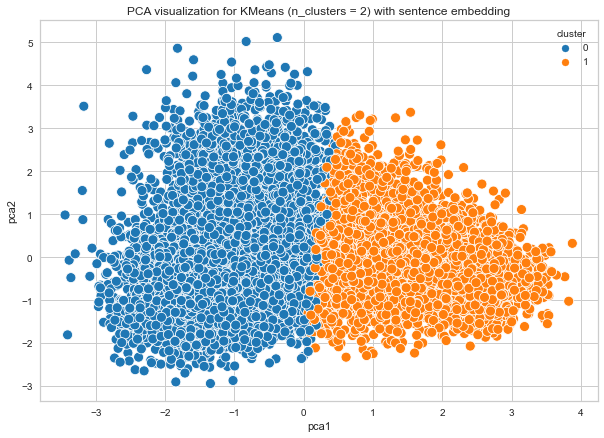

In [55]:
# PCA visualization for KMeans (n_clusters = 2, random_state=123) with sentence embedding representation
kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(emb_sents_recipe)

plot_pca_clusters(
    emb_sents_recipe,
    kmeans_2.predict(emb_sents_recipe).tolist(),
    size=100,
    title="PCA visualization for KMeans (n_clusters = 2) with sentence embedding",
)

**n_clusters = 3**

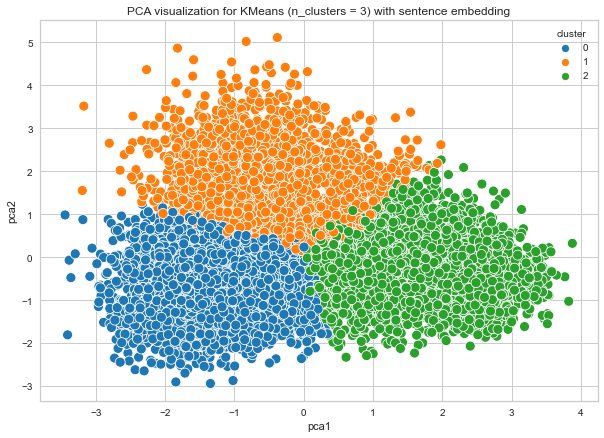

In [56]:
# PCA visualization for KMeans (n_clusters = 3) with sentence embedding representation
kmeans_3 = KMeans(n_clusters=3, random_state=123)
kmeans_3.fit(emb_sents_recipe)

plot_pca_clusters(
    emb_sents_recipe,
    kmeans_3.predict(emb_sents_recipe).tolist(),
    size=100,
    title="PCA visualization for KMeans (n_clusters = 3) with sentence embedding",
)

**n_clusters = 4**

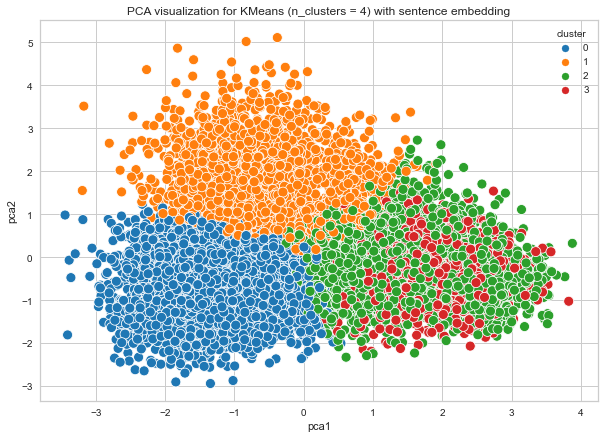

In [57]:
# PCA visualization for KMeans (n_clusters = 4) with sentence embedding representation
kmeans_4 = KMeans(n_clusters=4, random_state=123)
kmeans_4.fit(emb_sents_recipe)

plot_pca_clusters(
    emb_sents_recipe,
    kmeans_4.predict(emb_sents_recipe).tolist(),
    size=100,
    title="PCA visualization for KMeans (n_clusters = 4) with sentence embedding",
)

Based on PCA plots, for `K=3` the clusters seem to be well separated and given above visualizations **3** clusters seem to be appropriate for this problem.

Now, Let's move on.

An important step in evaluation of the models built in clustering in the manual interpretations of the clusters.

Let's now examine some samples from different clusters given by `K-Means` model with the beest vlaue for `n_clusters`.

**Note:** Even when you use the `random_state` argument for `KMeans`, the cluster labels will change. So if you try to assign a manual topic to a cluster, the association would change if you rerun the code.

In [58]:
# Training KMeans with n_clusters = 3
kmeans_3 = KMeans(n_clusters=3, random_state=123)
kmeans_3.fit(emb_sents_recipe)
labels = kmeans_3.labels_
labels

array([2, 2, 2, ..., 0, 1, 0])

In [59]:
# Adding the cluster column to the original dataframe
recipes_df["cluster"] = labels
recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cluster
42,i yam what i yam muffins,93958,45,133174,2004-06-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]",10,"['preheat oven to 375 degrees', 'spray muffin tin with non-stick cooking spray and set aside', 'place the raisins in a small bowl and pour the 1 / 4 cup boiling water over them', 'cover and set aside while preparing batter', 'combine the flours , cocoa , baking powder , cinnamon , cloves , baking soda , and salt', 'lightly beat eggs with sorghum , oil , mashed yams and orange juice', 'add the egg mixture and buttermilk alternately to the dry ingredients , stir until well blended', 'drain the raisins and add to batter along with orange peel', 'spoon batter into prepared muffin tins , sprinkle 1 / 4 to 1 / 2 tsp of granulated sugar over each muffin', 'bake in preheated oven for 15 to 20 minutes']","these muffins may have slightly different ingredients but the end result is a wonderful rich, moist muffin. the sugar sprinkled on top before cooking gives a slightly sweet crunch and cracked glazed appearance.","['all-purpose flour', 'buckwheat flour', 'unsweetened cocoa', 'baking powder', 'baking soda', 'salt', 'ground cinnamon', 'ground cloves', 'sorghum', 'eggs', 'yam', 'low-fat buttermilk', 'orange rind', 'orange juice', 'canola oil', 'raisins', 'boiling water', 'granulated sugar']",18,2
101,to your health muffins,61973,40,33823,2003-05-12,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[159.0, 8.0, 58.0, 10.0, 7.0, 4.0, 8.0]",5,"['blend together in large bowl flour , bran , brown sugar , baking soda , salt , cinnamon , carrots and raisins', 'in second bowl , beat buttermilk , oil , egg and vanilla', 'add liquid ingredients to dry ingredients and mix just until moistened', 'spoon into 12 greased or paper-lined muffin cups', 'bake at 375f for 20 minutes']","these muffins sound like they are very healthy for you, and pretty easy to make. another one of my great finds. to your health. enjoy","['whole wheat flour', 'natural bran', 'brown sugar', 'baking soda', 'salt', 'cinnamon', 'carrot', 'raisins', 'buttermilk', 'corn oil', 'egg', 'vanilla']",12,2
129,250 00 chocolate chip cookies,118843,20,145599,2005-04-24,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'drop-cookies', 'desserts', 'easy', 'cookies-and-brownies', '3-steps-or-less']","[5286.9, 427.0, 1630.0, 159.0, 163.0, 656.0, 224.0]",3,"['mix all ingredients together just until blended', 'spoon large tbspfuls onto a baking sheet', 'bake at 350 for 10-14 minutes']",these are great! the perfect name for them!,"['butter', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'oatmeal', 'salt', 'baking powder', 'baking soda', 'chocolate chips', ""hershey's semi-sweet baking chocolate"", 'nuts']",13,2
138,lplermagronen,455351,55,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'preparation']","[651.8, 33.0, 12.0, 16.0, 32.0, 63.0, 33.0]",15,"['heat oven to 375f set a large pot of salted water to boil', 'heat butter / oil over medium-low heat in a frying pan', 'add onions and fry them until golden brown', 'add penne and potatoes to the salted water', 'stir to make sure pasta doesnt stick together', 'cook until tender , about 15 minutes', 'drain penne and potatoes', 'combine milk / cream with salt and pepper', 'in an ovenproof casserole dish , place 1 / 3 of the penne-potatoes , sprinkle with 1 / 2 of the grated cheese', 'make another layer with 1 / 3 of the penne-potatoes , sprinkle with the other 1 / 2 of the grated cheese', 'top with the remaining 1 / 3 of the penne-potatoes', 'pour the seasoned milk / cream evenly over the top', 'spread the browned onions on top', 'bake covered for 10-15 minutes until steaming hot and cheese is melted', 'serve with warmed applesauce']","known as sw

In [60]:
# 10 samples from cluster labeled 0
recipes_df.loc[recipes_df["cluster"] == 0].head(10)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cluster
163,california roll salad,318677,12,334242,2008-08-11,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'salads']","[455.7, 13.0, 38.0, 72.0, 34.0, 6.0, 26.0]",8,"['prepare rice according to directions', 'pour rice into medium bowl and toss with 1 tbsp vinegar', 'set aside', 'thinly slice cucumber and avacado', 'break up crabmeat into chunks', 'mix lettuce leaves with seasoned rice , cucumber , avocado slices and crabmeat', 'in separate cup , mix together soy sauce and remaining 2 tbl of seasoned rice vinegar', 'drizzle this dressing over salad , and add pickled ginger on top of salad']","this is a great light salad that can be your main meal or a side dish. if you like the sushi taste minus the raw fish, this one is for you! it is very easy to throw together. you can buy pickled ginger at supermarkets in little bowls, usually by where they sell packaged sushi.","['white rice', 'seasoned rice vinegar', 'lettuce', 'cucumber', 'avocado', 'imitation crabmeat', 'soy sauce', 'pickled ginger']",8,0
169,chef salad dressing,176110,10,57256,2006-07-04,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'salads', 'easy', 'salad-dressings', 'dietary', '3-steps-or-less']","[447.0, 46.0, 175.0, 32.0, 1.0, 19.0, 15.0]",3,"['mix all ingredients until smooth and well blended', 'store in refrigerator', 'will keep up to 2 weeks']","this is a wonderful blend of ingredients for a ""chef salad"". great hot weather food ! sliced turkey or chicken, shrimp, sliced ham, cheese, hard boiled eggs, olives, pickled beets, some sliced red onion and any and all other ingredients tossed with cold crisp lettuce! this is perfect! it will keep , refrigerated of course for up to 2 weeks!","['miracle whip', 'sugar', 'cider vinegar', 'ketchup', 'vegetable oil', 'pepper', 'garlic clove', 'salt', 'dry mustard', 'paprika', 'tabasco sauce']",11,0
337,buffalo wing mushrooms,535020,30,33186,2018-01-29,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'appetizers']","[2526.8, 345.0, 35.0, 106.0, 43.0, 87.0, 37.0]",8,"['in a medium-large mixing bowl , add in panko breadcrumbs and set aside', 'in a medium sized bowl , mix together flour , cornstarch , salt and black pepper', 'slowly whisk in water , making sure that it is not clumpy', 'in batches of three to four , drop in hen of the woods mushrooms into slurry then promptly into breadcrumbs', 'toss mushrooms in panko until the mushrooms are completely coated', 'remove the mushrooms from bowl and set out on a baking tray , making sure not to stack them up', 'bring four cups of canola oil up to 350f in a two-quart pot and drop in mushrooms', 'fry until golden brown and toss in hot sauce']",courtesy of ps kitchen.,"['mushrooms', 'cornstarch', 'all-purpose flour', 'salt', 'ground black pepper', 'seltzer water', 'panko breadcrumbs', 'canola oil']",8,0
399,green soup,391390,60,1360982,2009-09-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'soups-stews']","[500.7, 12.0, 56.0, 52.0, 52.0, 10.0, 27.0]",8,"['cook the barley in the stock for about 15 minutes', 'add onion , celery , pepper and garlic and cook 15 minutes', 'add potatoes and simmer till the potatoes are almost done', 'add your greens and cook 5-7 minutes', 'you can mix whatever greens you like', 'if using artichokes , add when you add your greens', 'taste and correct seasoning', 'you may need to add additional stock as you cook']",light soup thats good and good for you.,"['quick-cooking barley', 'onion', 'celery', 'pepper', 'garlic cloves', 'potatoes', 'spinach', 'chicken stock', 'artichoke hearts']",9,0
418,i coulda had a stuffed pepper stuffed peppers,341816,85,133933,2008-12-05,"['time-to-make', 'course', 'main-ingredient', 'preparation', 'main-dish', 'beef', 'ground-beef', 'meat', '4-hours-or-less']","[213.4, 13.0, 32.0, 34.0, 36.0, 17.0, 5.0]",15,"['preheat oven to 350', 'cut the stems 

In [61]:
# 10 samples from cluster labeled 1
recipes_df.loc[recipes_df["cluster"] == 1].head(10)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cluster
138,lplermagronen,455351,55,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'preparation']","[651.8, 33.0, 12.0, 16.0, 32.0, 63.0, 33.0]",15,"['heat oven to 375f set a large pot of salted water to boil', 'heat butter / oil over medium-low heat in a frying pan', 'add onions and fry them until golden brown', 'add penne and potatoes to the salted water', 'stir to make sure pasta doesnt stick together', 'cook until tender , about 15 minutes', 'drain penne and potatoes', 'combine milk / cream with salt and pepper', 'in an ovenproof casserole dish , place 1 / 3 of the penne-potatoes , sprinkle with 1 / 2 of the grated cheese', 'make another layer with 1 / 3 of the penne-potatoes , sprinkle with the other 1 / 2 of the grated cheese', 'top with the remaining 1 / 3 of the penne-potatoes', 'pour the seasoned milk / cream evenly over the top', 'spread the browned onions on top', 'bake covered for 10-15 minutes until steaming hot and cheese is melted', 'serve with warmed applesauce']","known as swiss mac n cheese, älplermagronen was traditionally a dish of peasant farmers served with apple sauce. taken from growchew.wordpress.com and posted for zwt7","['potato', 'penne pasta', 'onions', 'butter', 'cheese', 'milk', 'salt and pepper', 'applesauce']",8,1
456,marco polenta,354047,40,527886,2009-02-05,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'main-dish']","[167.3, 8.0, 8.0, 11.0, 12.0, 5.0, 8.0]",16,"['in a boiler , simmer chickpeas , including liquid , with red pepper flakes and garlic for about 20 minutes', 'meanwhile , drain spinach , reserving the liquid', 'in a large skillet , heat oil', 'add cardamon and cook for about a minute', 'add onions , garlic and ginger and saute until the onions are translucent', 'add spinach , then cinammon and coriander', 'reduce heat and simmer gently for about ten minutes , adding reserved spinach liquid as needed to keep the mixture moist', 'meanwhile , slice and grill polenta , using a dry skillet or stovetop grill', 'drain chickpeas and add to the spinach mixture', 'prepare for serving by placing two slices of polenta on each plate', 'use a slotted spoon to drain the spinach and chickpea mixture , and top each slice of polenta', '(ingredient', 'one cup dried chickpeas can be substituted for canned , by soaking overnight and then cooking until tender', 'one pound fresh spinach , wash and deveined , can be substituted for frozen', 'dried ground cardamon and ginger can be substituted for fresh', ')']","start with the italian cornmeal classic, polenta, and add the exotic new\r\nflavors of marco polo's journey to the east: chickpeas from anatolia,\r\nspinach from persia, cardamon from india and cinnamon from china. but don't\r\nworry, this recipe doesn't take years to complete! prepared polenta and\r\ncanned chickpeas make it easy (and nutritious).","['chickpeas', 'red pepper flakes', 'garlic cloves', 'frozen spinach', 'peanut oil', 'cardamom pods', 'onions', 'ginger', 'cinnamon', 'coriander', 'prepared polenta']",11,1
535,starbucks oat fudge bars,343821,45,946392,2008-12-15,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'desserts', 'cookies-and-brownies', 'bar-cookies']","[397.2, 28.0, 127.0, 7.0, 13.0, 54.0, 18.0]",6,"['cream butter , sugar and eggs', 'mix flour , soda and oats and add slowly to creamed mixture', 'spread 3 / 4 of this into 9x13 pan', 'melt remaining ingredients in a saucepan and pour over dough in pan', 'blob the remaining oat mixture on top', 'bake at 350 for 25 minutes']",i am always tempted to buy these at starbucks so when a friend brought these to a cookie exchange i was quite excited!,"['sugar', 'brown sugar', 'butter', 'eggs', 'flour', 'baking soda', 'oats', 'sweetened condensed milk', 'chocolate chips', 'vanilla']",10,1
554,the ultimate brownie,342698,55,850974,2008-12-09,"['60-minutes-or-less', 'time-to-make', 'cour

In [62]:
# 10 samples from cluster labeled 2
recipes_df.loc[recipes_df["cluster"] == 2].head(10)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cluster
42,i yam what i yam muffins,93958,45,133174,2004-06-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]",10,"['preheat oven to 375 degrees', 'spray muffin tin with non-stick cooking spray and set aside', 'place the raisins in a small bowl and pour the 1 / 4 cup boiling water over them', 'cover and set aside while preparing batter', 'combine the flours , cocoa , baking powder , cinnamon , cloves , baking soda , and salt', 'lightly beat eggs with sorghum , oil , mashed yams and orange juice', 'add the egg mixture and buttermilk alternately to the dry ingredients , stir until well blended', 'drain the raisins and add to batter along with orange peel', 'spoon batter into prepared muffin tins , sprinkle 1 / 4 to 1 / 2 tsp of granulated sugar over each muffin', 'bake in preheated oven for 15 to 20 minutes']","these muffins may have slightly different ingredients but the end result is a wonderful rich, moist muffin. the sugar sprinkled on top before cooking gives a slightly sweet crunch and cracked glazed appearance.","['all-purpose flour', 'buckwheat flour', 'unsweetened cocoa', 'baking powder', 'baking soda', 'salt', 'ground cinnamon', 'ground cloves', 'sorghum', 'eggs', 'yam', 'low-fat buttermilk', 'orange rind', 'orange juice', 'canola oil', 'raisins', 'boiling water', 'granulated sugar']",18,2
101,to your health muffins,61973,40,33823,2003-05-12,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[159.0, 8.0, 58.0, 10.0, 7.0, 4.0, 8.0]",5,"['blend together in large bowl flour , bran , brown sugar , baking soda , salt , cinnamon , carrots and raisins', 'in second bowl , beat buttermilk , oil , egg and vanilla', 'add liquid ingredients to dry ingredients and mix just until moistened', 'spoon into 12 greased or paper-lined muffin cups', 'bake at 375f for 20 minutes']","these muffins sound like they are very healthy for you, and pretty easy to make. another one of my great finds. to your health. enjoy","['whole wheat flour', 'natural bran', 'brown sugar', 'baking soda', 'salt', 'cinnamon', 'carrot', 'raisins', 'buttermilk', 'corn oil', 'egg', 'vanilla']",12,2
129,250 00 chocolate chip cookies,118843,20,145599,2005-04-24,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'drop-cookies', 'desserts', 'easy', 'cookies-and-brownies', '3-steps-or-less']","[5286.9, 427.0, 1630.0, 159.0, 163.0, 656.0, 224.0]",3,"['mix all ingredients together just until blended', 'spoon large tbspfuls onto a baking sheet', 'bake at 350 for 10-14 minutes']",these are great! the perfect name for them!,"['butter', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'oatmeal', 'salt', 'baking powder', 'baking soda', 'chocolate chips', ""hershey's semi-sweet baking chocolate"", 'nuts']",13,2
234,ma s oatmeal cake and icing,261215,45,568297,2007-10-25,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'desserts', 'cakes']","[366.5, 29.0, 120.0, 16.0, 8.0, 30.0, 15.0]",7,"['in a small bowl combine quick oats , margarine , and boiling water', 'cover and allow margarine to melt , and mixture to cool a bit', 'mix remaining cake ingredients and mix well', 'spread into 9x13 greased and lightly floured cake pan', 'bake at 350f for approximately 35 minutes or until done', 'for icing: mix icing ingredients until well blended', 'spread over cooled cake and put under broiler until coconut browns']","this recipe is a very old family recipe that came from my great grandmother who passed in 1988 at the age of 87. this a very heavy, moist cake. hope you enjoy it as much as our family has for many years.","['boiling water', 'quick oats', 'margarine', 'brown sugar', 'flour', 'eggs', 'salt', 'cinnamon', 'nutmeg', 'baking soda', 'shredded coconut', 'vanilla', 'cream', 'nuts']",14,2
262,rea

It is obvious that there seems to be a good distinction made by the clustering. The lable `0 `here is associated with drinks like cocktails or martini, label `1` refers to some sort of dessert meals like cakes or muffins and finally label `2` is centered around main courses or appetizers like chicken or pasta fagioli

We are on track, right? 🚀

Recall that we have other attributes such as `minutes`, `n_steps`, `n_ingredients` in the `recipes_df`. Let's examine these attributes for different clusters.

To do so, for each cluster, I will show average of minutes, n_steps, n_ingredients.

In [63]:
print("The avg of minutes (cluster 0):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 0)[0]]["minutes"]))
print("The avg of minutes (cluster 1):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 1)[0]]["minutes"]))
print("The avg of minutes (cluster 2):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 2)[0]]["minutes"]))

print("The avg of n_steps (cluster 0):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 0)[0]]["n_steps"]))
print("The avg of n_steps (cluster 1):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 1)[0]]["n_steps"]))
print("The avg of n_steps (cluster 2):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 2)[0]]["n_steps"]))

print("The avg of n_ingredients (cluster 0):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 0)[0]]["n_ingredients"]))
print("The avg of n_ingredients (cluster 1):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 1)[0]]["n_ingredients"]))
print("The avg of n_ingredients (cluster 2):", np.mean(recipes_df.iloc[np.where(kmeans_3.labels_ == 2)[0]]["n_ingredients"]))

The avg of minutes (cluster 0): 57.51053215077605
The avg of minutes (cluster 1): 25.923381117152744
The avg of minutes (cluster 2): 54.25713462092822
The avg of n_steps (cluster 0): 10.611973392461197
The avg of n_steps (cluster 1): 7.020266930301532
The avg of n_steps (cluster 2): 12.169501297203805
The avg of n_ingredients (cluster 0): 10.529656319290465
The avg of n_ingredients (cluster 1): 7.102817597627286
The avg of n_ingredients (cluster 2): 10.092245603920437


Looks like there are striking differences in the values of these features between clusters. Based on the results cluster `0` needs less time to cook and has fewer steps and ingredients than the other two clusters, which again make total sense.

Let's examine the `tags` associated with different clusters. Each recipe has a list of tags given in the **Tags** column. I could, for instance, find the most common items in tags for each recipe.

In [64]:
# Most common items in tags associated with cluster label 0
recipes_df.loc[recipes_df["cluster"] == 0]["tags"].value_counts().idxmax()

"['60-minutes-or-less', 'time-to-make', 'preparation']"

In [65]:
# Most common items in tags associated with cluster label 1
recipes_df.loc[recipes_df["cluster"] == 1]["tags"].value_counts().idxmax()

"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-1-or-2', '5-ingredients-or-less', 'beverages', 'easy', 'cocktails', 'number-of-servings', '3-steps-or-less']"

In [66]:
# Most common items in tags associated with cluster label 2
recipes_df.loc[recipes_df["cluster"] == 2]["tags"].value_counts().idxmax()

"['time-to-make', 'course', 'preparation', 'desserts', 'cakes', '4-hours-or-less']"

Based on the results above, certain tags in the clusters do relate to the cluster in which they are in. For example for cluster `0` (drinks), 15-minutes-or-less tag makes sense or for cluster `2` (main courses), 60-minutes-or-less tag makes sense too.

In the next step, I will cluster the recipes using [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) with sentence embedding representation and cosine distance metric. Next, I will use the method to pick reasonable values for the hyperparameters `eps` and `min_samples`.

In [67]:
# Picking reasonable values for eps and min_samples for DBSCAN
for epsilon in np.arange(0.1, 1, 0.3):
    for min_samp in np.arange(10, 20, 5):       
        dbscan = DBSCAN(eps = epsilon, min_samples = min_samp, metric = 'cosine')
        dbscan.fit(emb_sents_recipe)

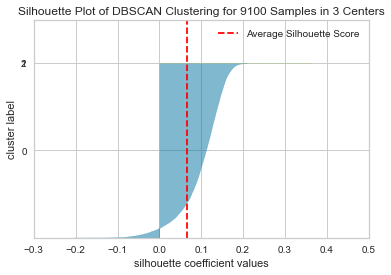

In [68]:
# Training DBSCAN for eps = 0.4 and min_samples = 10
dbscan = DBSCAN(eps=0.4, min_samples=10, metric='cosine')
dbscan.fit(emb_sents_recipe)
n_clusters = len(set(dbscan.labels_))
dbscan.n_clusters = n_clusters
dbscan.predict = lambda x: dbscan.labels_

# Silhouette Method
visualizer = SilhouetteVisualizer(dbscan, colors="yellowbrick")
visualizer.fit(emb_sents_recipe)
visualizer.show();

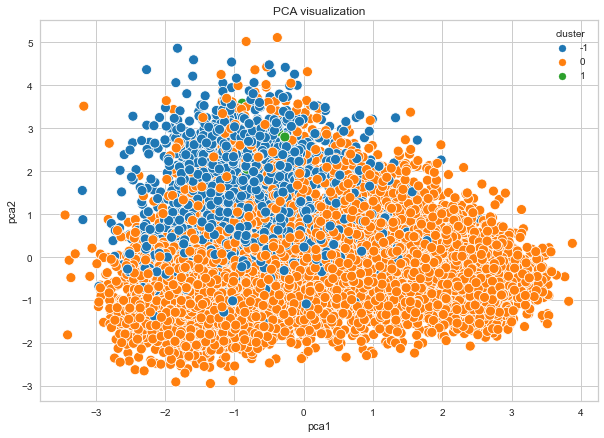

In [69]:
# PCA Visualization Method
plot_pca_clusters(emb_sents_recipe, dbscan.labels_.tolist())

Based on the results from `Silhouette` and PCA plots, `eps=0.4` and `min_samples=10` seem to be reasonable values for these hyperparameters as the clustering is well separated.

As for the interpretation of the `DBSCAN` clusters I will examine some examples from different clusters given by the model.

In [70]:
# Determining labels for DBSCAN
labels = dbscan.labels_
labels

array([ 0,  0,  0, ...,  0, -1,  0], dtype=int64)

In [71]:
# Adding the cluster column to the original dataframe
recipes_df["cluster"] = labels
recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cluster
42,i yam what i yam muffins,93958,45,133174,2004-06-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]",10,"['preheat oven to 375 degrees', 'spray muffin tin with non-stick cooking spray and set aside', 'place the raisins in a small bowl and pour the 1 / 4 cup boiling water over them', 'cover and set aside while preparing batter', 'combine the flours , cocoa , baking powder , cinnamon , cloves , baking soda , and salt', 'lightly beat eggs with sorghum , oil , mashed yams and orange juice', 'add the egg mixture and buttermilk alternately to the dry ingredients , stir until well blended', 'drain the raisins and add to batter along with orange peel', 'spoon batter into prepared muffin tins , sprinkle 1 / 4 to 1 / 2 tsp of granulated sugar over each muffin', 'bake in preheated oven for 15 to 20 minutes']","these muffins may have slightly different ingredients but the end result is a wonderful rich, moist muffin. the sugar sprinkled on top before cooking gives a slightly sweet crunch and cracked glazed appearance.","['all-purpose flour', 'buckwheat flour', 'unsweetened cocoa', 'baking powder', 'baking soda', 'salt', 'ground cinnamon', 'ground cloves', 'sorghum', 'eggs', 'yam', 'low-fat buttermilk', 'orange rind', 'orange juice', 'canola oil', 'raisins', 'boiling water', 'granulated sugar']",18,0
101,to your health muffins,61973,40,33823,2003-05-12,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[159.0, 8.0, 58.0, 10.0, 7.0, 4.0, 8.0]",5,"['blend together in large bowl flour , bran , brown sugar , baking soda , salt , cinnamon , carrots and raisins', 'in second bowl , beat buttermilk , oil , egg and vanilla', 'add liquid ingredients to dry ingredients and mix just until moistened', 'spoon into 12 greased or paper-lined muffin cups', 'bake at 375f for 20 minutes']","these muffins sound like they are very healthy for you, and pretty easy to make. another one of my great finds. to your health. enjoy","['whole wheat flour', 'natural bran', 'brown sugar', 'baking soda', 'salt', 'cinnamon', 'carrot', 'raisins', 'buttermilk', 'corn oil', 'egg', 'vanilla']",12,0
129,250 00 chocolate chip cookies,118843,20,145599,2005-04-24,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'drop-cookies', 'desserts', 'easy', 'cookies-and-brownies', '3-steps-or-less']","[5286.9, 427.0, 1630.0, 159.0, 163.0, 656.0, 224.0]",3,"['mix all ingredients together just until blended', 'spoon large tbspfuls onto a baking sheet', 'bake at 350 for 10-14 minutes']",these are great! the perfect name for them!,"['butter', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'oatmeal', 'salt', 'baking powder', 'baking soda', 'chocolate chips', ""hershey's semi-sweet baking chocolate"", 'nuts']",13,0
138,lplermagronen,455351,55,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'preparation']","[651.8, 33.0, 12.0, 16.0, 32.0, 63.0, 33.0]",15,"['heat oven to 375f set a large pot of salted water to boil', 'heat butter / oil over medium-low heat in a frying pan', 'add onions and fry them until golden brown', 'add penne and potatoes to the salted water', 'stir to make sure pasta doesnt stick together', 'cook until tender , about 15 minutes', 'drain penne and potatoes', 'combine milk / cream with salt and pepper', 'in an ovenproof casserole dish , place 1 / 3 of the penne-potatoes , sprinkle with 1 / 2 of the grated cheese', 'make another layer with 1 / 3 of the penne-potatoes , sprinkle with the other 1 / 2 of the grated cheese', 'top with the remaining 1 / 3 of the penne-potatoes', 'pour the seasoned milk / cream evenly over the top', 'spread the browned onions on top', 'bake covered for 10-15 minutes until steaming hot and cheese is melted', 'serve with warmed applesauce']","known as sw

In [72]:
# Samples from cluster labeled 0
recipes_df.loc[recipes_df["cluster"] == 0].head(10)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cluster
42,i yam what i yam muffins,93958,45,133174,2004-06-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]",10,"['preheat oven to 375 degrees', 'spray muffin tin with non-stick cooking spray and set aside', 'place the raisins in a small bowl and pour the 1 / 4 cup boiling water over them', 'cover and set aside while preparing batter', 'combine the flours , cocoa , baking powder , cinnamon , cloves , baking soda , and salt', 'lightly beat eggs with sorghum , oil , mashed yams and orange juice', 'add the egg mixture and buttermilk alternately to the dry ingredients , stir until well blended', 'drain the raisins and add to batter along with orange peel', 'spoon batter into prepared muffin tins , sprinkle 1 / 4 to 1 / 2 tsp of granulated sugar over each muffin', 'bake in preheated oven for 15 to 20 minutes']","these muffins may have slightly different ingredients but the end result is a wonderful rich, moist muffin. the sugar sprinkled on top before cooking gives a slightly sweet crunch and cracked glazed appearance.","['all-purpose flour', 'buckwheat flour', 'unsweetened cocoa', 'baking powder', 'baking soda', 'salt', 'ground cinnamon', 'ground cloves', 'sorghum', 'eggs', 'yam', 'low-fat buttermilk', 'orange rind', 'orange juice', 'canola oil', 'raisins', 'boiling water', 'granulated sugar']",18,0
101,to your health muffins,61973,40,33823,2003-05-12,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[159.0, 8.0, 58.0, 10.0, 7.0, 4.0, 8.0]",5,"['blend together in large bowl flour , bran , brown sugar , baking soda , salt , cinnamon , carrots and raisins', 'in second bowl , beat buttermilk , oil , egg and vanilla', 'add liquid ingredients to dry ingredients and mix just until moistened', 'spoon into 12 greased or paper-lined muffin cups', 'bake at 375f for 20 minutes']","these muffins sound like they are very healthy for you, and pretty easy to make. another one of my great finds. to your health. enjoy","['whole wheat flour', 'natural bran', 'brown sugar', 'baking soda', 'salt', 'cinnamon', 'carrot', 'raisins', 'buttermilk', 'corn oil', 'egg', 'vanilla']",12,0
129,250 00 chocolate chip cookies,118843,20,145599,2005-04-24,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'drop-cookies', 'desserts', 'easy', 'cookies-and-brownies', '3-steps-or-less']","[5286.9, 427.0, 1630.0, 159.0, 163.0, 656.0, 224.0]",3,"['mix all ingredients together just until blended', 'spoon large tbspfuls onto a baking sheet', 'bake at 350 for 10-14 minutes']",these are great! the perfect name for them!,"['butter', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'oatmeal', 'salt', 'baking powder', 'baking soda', 'chocolate chips', ""hershey's semi-sweet baking chocolate"", 'nuts']",13,0
163,california roll salad,318677,12,334242,2008-08-11,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'salads']","[455.7, 13.0, 38.0, 72.0, 34.0, 6.0, 26.0]",8,"['prepare rice according to directions', 'pour rice into medium bowl and toss with 1 tbsp vinegar', 'set aside', 'thinly slice cucumber and avacado', 'break up crabmeat into chunks', 'mix lettuce leaves with seasoned rice , cucumber , avocado slices and crabmeat', 'in separate cup , mix together soy sauce and remaining 2 tbl of seasoned rice vinegar', 'drizzle this dressing over salad , and add pickled ginger on top of salad']","this is a great light salad that can be your main meal or a side dish. if you like the sushi taste minus the raw fish, this one is for you! it is very easy to throw together. you can buy pickled ginger at supermarkets in little bowls, usually by where they sell packaged sushi.","['white rice', 'seasoned rice vinegar', 'lettuce', 'cucumber', 'avocado', 'imitation crabmeat', 'soy sauce', 'pickled gi

In [73]:
# Samples from cluster labeled 1
recipes_df.loc[recipes_df["cluster"] == 1].head(10)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cluster
24915,blackberry tequila sunrise,226044,5,246844,2007-05-03,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-1-or-2', '5-ingredients-or-less', 'beverages', 'easy', 'cocktails', 'number-of-servings']","[58.4, 0.0, 42.0, 0.0, 1.0, 0.0, 4.0]",5,"['fill tall glass 3 / 4 full with ice', 'add orange juice and tequila and stir to blend', 'add the chambord , letting in sink to the bottom', 'top with club soda if desired', 'squeeze lime wedge into glass and drop wedge into glass']","love these but only make now and again because chambord, a black raspberry liqueur can be hard to find (for me anyway) and expensive-makes a superior drink though.","['fresh orange juice', 'tequila', 'chambord raspberry liquor', 'lime wedge', 'club soda']",5,1
25042,blastoff tequila,222563,1,478607,2007-04-14,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-1-or-2', '5-ingredients-or-less', 'beverages', 'easy', 'cocktails', 'number-of-servings', '3-steps-or-less']","[60.6, 0.0, 45.0, 0.0, 0.0, 0.0, 4.0]",3,"['pour the tequila and pineapple juice into a highball glas almost filled with ice cubes', 'stir well', 'drop the curacao into the center of the drink']",this tequila drink is a favorite of many of my costomers. i know you will love it.\r\nit tastes so good.,"['blue curacao', 'pineapple juice', 'tequila']",3,1
110593,ila s iced tequila,243079,15,165623,2007-07-29,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'beverages', 'easy', '3-steps-or-less']","[66.3, 0.0, 67.0, 0.0, 0.0, 0.0, 5.0]",5,"['in a small saucepan , combine the sugar and water', 'bring to a simmer over moderately high heat , stirring to dissolve the sugar', 'remove the heat and let cool to room temperature stir in lemon juice', 'in a large pitcher , combine the lemon syrup with the guava nectar , tea and tequila', 'pour the tequila into tall glasses over ice and garnish each with a lemon twist']",this is so good right away but even better if refrigerated overnight.,"['sugar', 'water', 'fresh lemon juice', 'guava nectar', 'earl grey tea', 'tequila', 'lemon twist']",7,1
209481,tequila canyon,226122,5,37779,2007-05-03,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-1-or-2', '5-ingredients-or-less', 'beverages', 'easy', 'cocktails', 'dietary', 'number-of-servings', '3-steps-or-less']","[74.2, 0.0, 64.0, 0.0, 0.0, 0.0, 6.0]",5,"['add the first 3 ingredients into a highball filled with ice', 'stir', 'add in the pineapple and orange juices', 'garnish with a lime slice', 'serve with a stirrer']",a fruity tequila drink,"['tequila', 'triple sec', 'cranberry juice', 'pineapple juice', 'fresh orange juice']",5,1
209499,tequila jazz,331143,3,92006,2008-10-16,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-1-or-2', '5-ingredients-or-less', 'beverages', 'easy', 'cocktails', 'number-of-servings', '3-steps-or-less']","[10.5, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0]",1,['mix everything in a cocktail shaker and serve in a cold martini glass'],"i found this online, i haven't tried it but posted it for safe-keeping.","['tequila', 'blue curacao', 'orange juice', 'cointreau liqueur']",4,1
209518,tequila paralizer,341543,10,128473,2008-12-03,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-1-or-2', '5-ingredients-or-less', 'beverages', 'easy', 'cocktails', 'number-of-servings', '3-steps-or-less']","[143.2, 1.0, 78.0, 1.0, 4.0, 1.0, 6.0]",2,"['in a large chilled glass , add your ice cubes , tequila and kahlua add milk , stir and top with coke', ""sit back , close your eyes and enjoy , remember this isn't a milkshake and it has a great kick""]","this was my favorite cocktail, once upon a time...i can't believe that it's not already posted here...so here we go. i hope that you will enjoy this boozy drink that tastes like a milkshake...but has a big kick.","['white tequila', 'kahlua', '1% 

The data points with label `-1` are considered `Noise` points. Let's see how many noise points are there.

In [74]:
list(dbscan.labels_).count(-1)

1764

In a sense, `DBSCAN` has done a good job in clustering the datapoints as it has masterfully separated the **tequila** drinks from other recipe names. But it is possible that by tuning the hyperparameters of `DBSCAN` we may get more reasonable distinctions with less **Noise** points.

[Dendrograms](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) are sutiable to display hierarchical clustering. Here, I will plot the dendrogram for the first 50 items from `recipes_df` using **average linkage** and **ward linkage**.

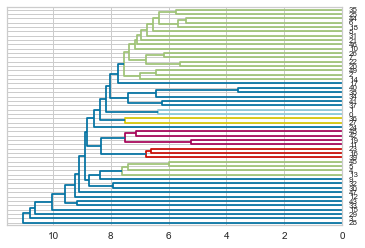

In [75]:
# Dendrogram using average linkage
Z_avg = average(emb_sents_recipe[0:50, ])
dendrogram(Z_avg, orientation="left");

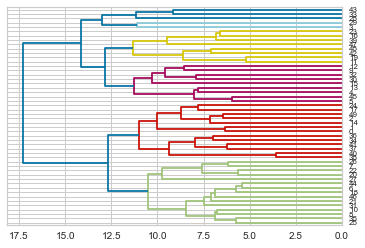

In [76]:
# Dendrogram using ward linkage
Z_ward = ward(emb_sents_recipe[0:50, ])
dendrogram(Z_ward, orientation="left");

Based on the dendrogram plots above, we can see that the data points associated with the blue cluster have long branches i.e. we will be merging far apart from these points. In other words these mergeed clusters in blue persist for a long time.

### 5- Summary

In this script, I have made an attempt to run document clustering on the the [Kaggle's Food.com recipes corpus](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) data set. I have made use of various models such as `K-Means` and `DBSCAN` to do this and analyzed the resulting clusters manually.

**This is the end of the notebook.**